In [1]:
import math
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.rcParams['image.cmap'] = 'gray'

### import functions from scripts

In [2]:
import os
os.chdir('saliency_model/')

In [3]:
from utils import *
from itti_koch_features import *
import cv2 as cv

## Load the images

In [4]:
# img = mpimg.imread('../imgs/67.jpg')
img = mpimg.imread('../imgs/balloons.png')

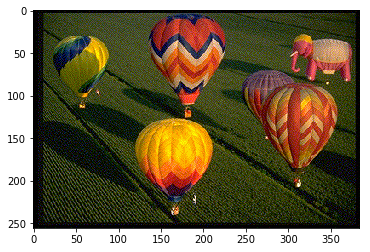

In [5]:
plt.imshow(img);

convert to double if image is uint8

In [6]:
# TODO 

---

## Determine the size and the number of center scales:  
First we scale the image to different sizes, so it has different resolutions we can work with.

In [7]:
mapwidth = 64
mapheight = round(img.shape[0] * (mapwidth / img.shape[1]))
scalars = [1, 2, 3]

img_scales = downsample_image(img, mapheight, mapwidth, scalars)

In [8]:
mapsize = [ round(np.size(img,0) / np.size(img,1) * mapwidth), mapwidth ];
mapsize
# chanmap = chanmap + wj * imresize(maps{ci}{cj}, mapSize ); #TODO: weighted scale

[43, 64]

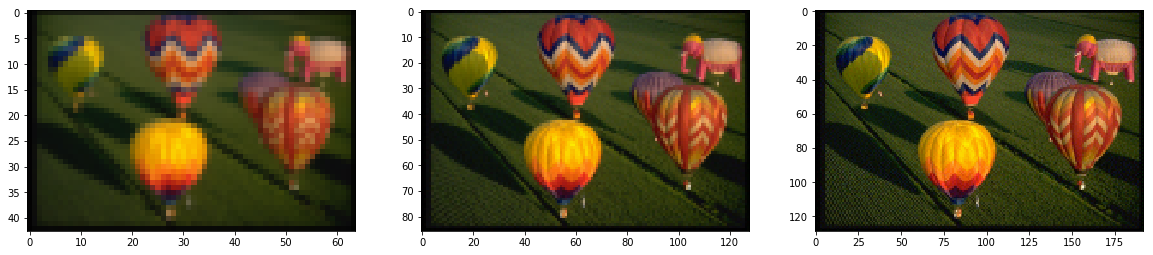

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_scales[0])
ax[1].imshow(img_scales[1])
ax[2].imshow(img_scales[2]);

---

## CHANNELS

### Channel 1: Compute Colors

In [10]:
img = img_scales[2]
r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

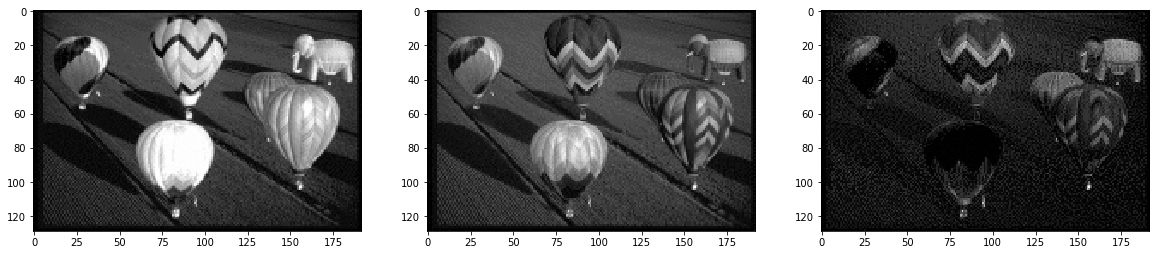

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(r)
ax[1].imshow(g)
ax[2].imshow(b);

## SALIENCY
### (1) apply center-surround to feature map

Convolve the feature maps with the center surround function / Mexican Hat to get the saliency maps.

In [12]:
def convolve_receptive_field(input_list, sigma1, sigma2):
    """
    convolves all images of the input list with the sigma-combinations;
    returns a nested list of convolved images, where the first index is associated with the image,
    and the second index is associated with the sigmas (kernel-size)
    """
    if (len(sigma1) != len(sigma2)):
        # TODO make this a useful error message...
        print("Amount of sigmas for inner and outer Gaussian have to be the same!")
        return
        
    # outer loop over the images
    output_list = []
    for img in input_list:
        
        # inner loop over the sigma-combinations
        img_hat = []
        for s1, s2 in zip(sigma1, sigma2):
            print(s1, s2)
            # create receptive field and convolve with image
            rf1 = receptive_field_matrix(lambda x, y: gaussian2D(x, y, s1))
            rf = receptive_field_matrix(lambda x, y: gaussian2D(x, y, s2))

            # list containing different kernel sizes
            img_conv = signal.convolve2d(img, rf1, mode='same')  # convolve image with narrow gaussian
            convolved = signal.convolve2d(img, rf, mode='same') # convolve image with wide gaussian
            
            # substract one conv. img with the other
            conv = (img_conv - convolved)**2
            
#             img_hat.append(conv)                     # save as 2D list
#             output_list.append(img_hat)

            output_list.append(conv) # save as 1D list
            
        # list containing convolved versions of all images
        
    return output_list

## RG BY calculations

In [13]:
colors = [r,g,b]
lum = np.mean(colors)

by = np.divide((b - np.minimum(r,g)), lum) # (B-Y)
rg = np.divide((r - g), lum); # (R-G)
col = [rg,by]

In [14]:
sigma1 = [1, 1]
sigma2 = [3, 4]
convolution_maps = convolve_receptive_field(col, sigma1, sigma2)

1 3
1 4
1 3
1 4


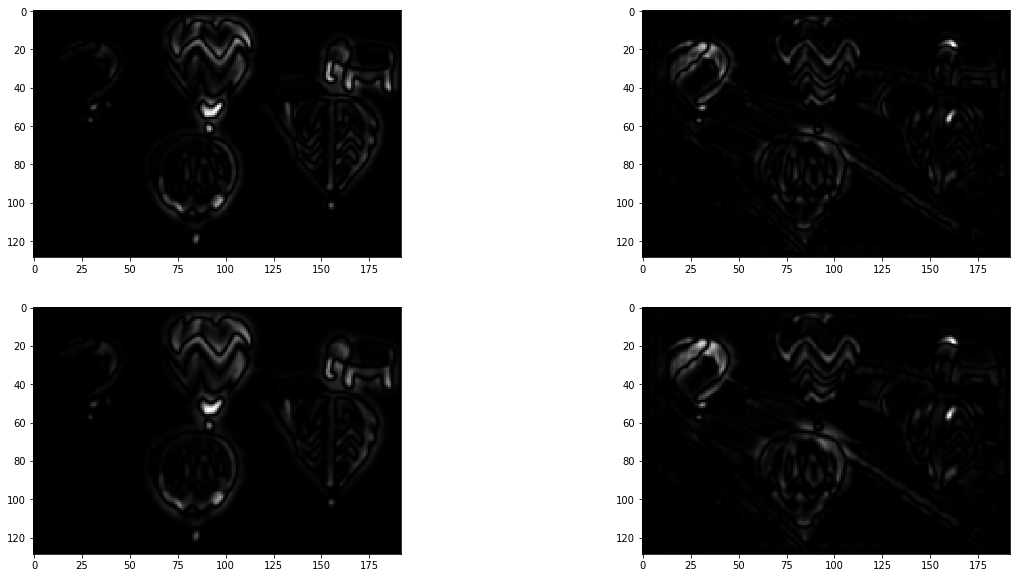

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0,0].imshow(convolution_maps[0])
ax[1,0].imshow(convolution_maps[1])
#ax[2,0].imshow(convolved[0][2])
ax[0,1].imshow(convolution_maps[2])
ax[1,1].imshow(convolution_maps[3]);

## *QUESTION*:
What is done in the original MATLAB code is the following:   
(1) create 1-dim Gausskernel and convolve it with the image twice (in two dimensions) - I think this should be the same as what we directly do in two dimensions? They also only use a Gaussian kernel and not a real receptive field...  
(2) after convolution, get the saliency map by subtracting the convoluted image from the original intensities and squaring the difference (see what happens when flagging matlab_code to True)

**Why would we have to do this?**

## (2) judge the peakiness of a saliency map

## Normalize to 0 - 1 range

In [16]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

In [17]:
def normalize(X):
    return (X - X.min()) / (X.max() - X.min())

In [18]:
convolution_maps[0].max()

2.0289324120994587

In [19]:
for i,m in enumerate(convolution_maps):
    convolution_maps[i] = normalize(m)

In [20]:
convolution_maps[0].max()

1.0

## Get weights for peakines

In [21]:
def get_local_maxima(sal_map, min_distance=1, threshold_abs=0.1):
    '''
    Input image, find local minima with min_distance window between points. 
    Return average of local minimas and their number
    '''
    
    coordinates = peak_local_max(sal_map, min_distance=min_distance, threshold_abs=threshold_abs)
    
    peak_avg = 0
    peak_num = np.shape(coordinates)[0]
        
    for x,y in coordinates:
        peak_avg = peak_avg + sal_map[x][y]
    
    peak_avg = peak_avg/peak_num
    
    return peak_avg, peak_num

In [22]:
def get_weight_map(peak_avg, peak_num):
    '''
    based on number of peaks and their average return weight of the map used for normalization
    measure of pickiness
    '''
    
    if peak_num <= 1:
        return 1
    else:
        return (1 - peak_avg)**2
            

In [23]:
weights = []

for i,m in enumerate(convolution_maps):
    peak_avg, peak_num = get_local_maxima(m, min_distance=1)
    weights.append(get_weight_map(peak_avg, peak_num))
    
weights

[0.5474955272792699,
 0.5652886717215396,
 0.6268385950946755,
 0.5786883483513722]

In [24]:
for i, m in enumerate(convolution_maps):
    convolution_maps[i] = weights[i] * m

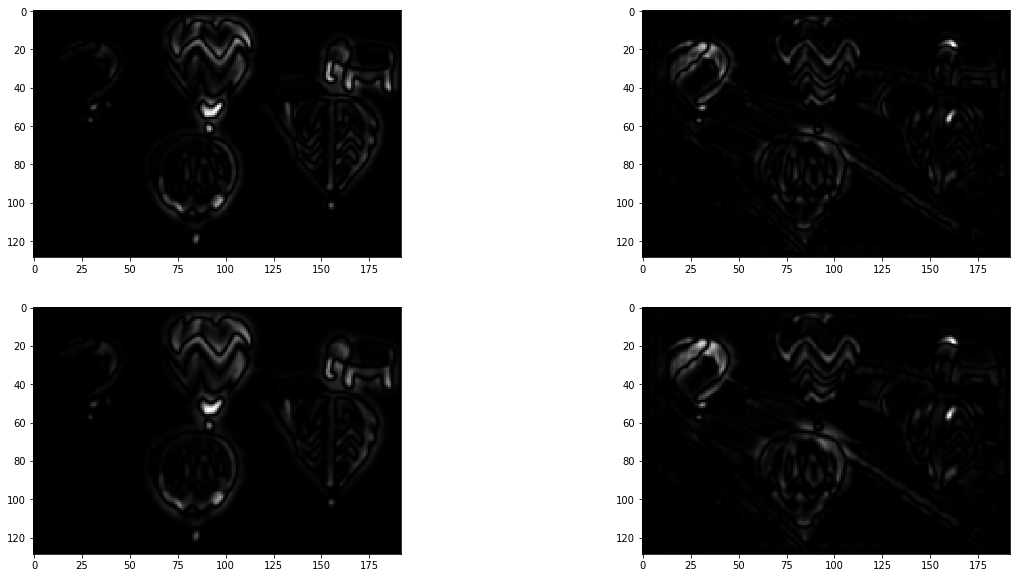

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0,0].imshow(convolution_maps[0])
ax[1,0].imshow(convolution_maps[1])
ax[0,1].imshow(convolution_maps[2])
ax[1,1].imshow(convolution_maps[3]);

## Sum the maps 

In [26]:
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from skimage.transform import resize
from scipy import ndimage as nd

In [27]:
conv_maps_resize = []

for ii in convolution_maps:
    temp = resize(ii, mapsize, mode='constant', anti_aliasing=True)
    conv_maps_resize.append(temp)

In [28]:
RG = np.zeros(mapsize)
BY = np.zeros(mapsize)

RG = conv_maps_resize[0] + conv_maps_resize[1]
BY = conv_maps_resize[2] + conv_maps_resize[3]

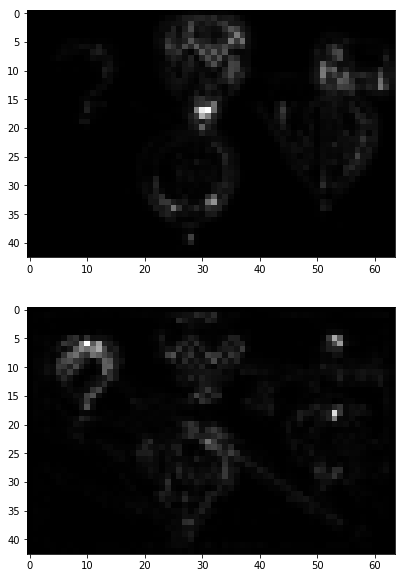

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].imshow(RG);
ax[1].imshow(BY);